In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trade = 'SIL'
based_on = 'BTC'

columns = [
            'Date', 
            'Open', 'Close',
            'Low', 'High',
            'Day Return'
           ]

In [3]:
def to_numeric(df, columns=columns):
    cols_present = columns.copy()
    for column in columns:
        if column not in df.columns:
            cols_present.remove(column)
            continue
        if column == 'Date':
            continue
        df[column] = df[column].astype(str)
        if '%' in df[column][0]:
            df[column] = df[column].str.replace('%','')
            df[column] = pd.to_numeric(df[column].str.replace(',','')) / 100
        else:
            df[column] = pd.to_numeric(df[column].str.replace(',',''))
    
    return df[cols_present]


def compute_overnight(df):
    df['Prev Night Return'] = df["Open"] / df["Close"].shift(1) - 1
    return df


def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

In [4]:
BTC = pd.read_csv('../Data/BTC.csv')
BTC['Date'] = pd.to_datetime(BTC['Date'])
BTC = BTC.sort_values('Date')\
        .reset_index()

BTC['Close'] = BTC['Price']
BTC = to_numeric(BTC)
BTC = compute_overnight(BTC)
BTC.columns = ['Date'] + [
                'BTC.' + column
                for column in BTC.columns
                if column != "Date"
    ]

SIL = pd.read_csv('../Data/SI=F.csv')\
        .dropna()\
        .reset_index().drop('index', axis=1)
SIL['Date'] = pd.to_datetime(SIL['Date'])
SIL = to_numeric(SIL)
SIL = compute_overnight(SIL)
SIL.columns = ['Date'] + [
                'SIL.' + column
                for column in SIL.columns
                if column != "Date"
    ]

merged = pd.merge(BTC, SIL, how='inner').dropna()
for etf in [trade, based_on]:
    merged[f'{etf}.Day Return'] = merged[f'{etf}.Close'].pct_change().fillna(0)

In [5]:
def strategy(df, trade, based_on):
    returns = (df[f'{based_on}.Prev Night Return'] > 0)\
                    .astype(int) \
                * df[f'{trade}.Day Return']
    return np.array(returns, dtype=np.longdouble)

def bnh(df, trade):
    returns = df[f'{trade}.Day Return']
    return np.array(returns, dtype=np.longdouble)

In [6]:
strategy_returns = pd.DataFrame({
                'Returns': strategy(merged, 
                                trade=trade, 
                                based_on=based_on),
                'Date': merged['Date']}).set_index('Date')

strategy_returns["Cumulative"] = (1 + strategy_returns["Returns"]).cumprod()

# Returns
strategy_returns["Year"] = strategy_returns.index.year
strategy_yearly_returns = (strategy_returns.groupby("Year")["Cumulative"].last() \
                    / strategy_returns.groupby("Year")["Cumulative"].first() - 1) * 100

# MDD
strategy_yearly_drawdowns = strategy_returns.groupby("Year")["Returns"].apply(max_drawdown) * 100

# Create a table for yearly returns
strategy_returns_table = pd.DataFrame({
    "Yearly Returns": strategy_yearly_returns,
    "Max Drawdown": strategy_yearly_drawdowns})
print(strategy_returns_table)

      Yearly Returns  Max Drawdown
Year                              
2014        0.000000      0.000000
2015        0.000000      0.000000
2016        0.000000      0.000000
2017       -2.908556     -5.517335
2018       -3.825236    -12.718149
2019        0.176242    -10.982407
2020       52.685104    -23.943412
2021      -17.417755    -31.084258
2022       20.359832    -20.044199
2023       -3.738847    -16.190690
2024       12.908330    -15.436169


In [7]:
bnh_returns = pd.DataFrame({
                'Returns': bnh(merged, 
                                trade=trade),
                'Date': merged['Date']}).set_index('Date')

bnh_returns["Cumulative"] = (1 + bnh_returns["Returns"]).cumprod()

# Returns
bnh_returns["Year"] = bnh_returns.index.year
bnh_yearly_returns = (bnh_returns.groupby("Year")["Cumulative"].last() \
                    / bnh_returns.groupby("Year")["Cumulative"].first() - 1) * 100

# MDD
bnh_yearly_drawdowns = bnh_returns.groupby("Year")["Returns"].apply(max_drawdown) * 100

# Create a table for yearly returns
bnh_returns_table = pd.DataFrame({
    "Yearly Returns": bnh_yearly_returns,
    "Max Drawdown": bnh_yearly_drawdowns})
print(bnh_returns_table)

      Yearly Returns  Max Drawdown
Year                              
2014      -22.509960    -30.204082
2015      -12.460267    -25.504087
2016       15.340087    -24.044509
2017        4.278729    -16.873986
2018       -9.871495    -20.512821
2019       14.736165    -15.007736
2020       46.521981    -37.837838
2021      -14.479472    -27.006803
2022        4.695042    -34.734102
2023       -0.872818    -19.900115
2024       22.671724    -16.702887


<Figure size 1200x1000 with 0 Axes>

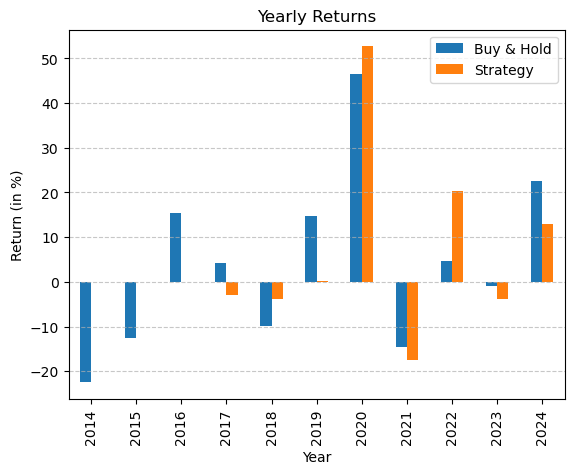

In [8]:
yearly_returns = pd.merge(bnh_yearly_returns.rename('Buy & Hold').reset_index(),
                           strategy_yearly_returns.rename('Strategy').reset_index(),
                            how='inner').dropna()
# Plot Yearly Returns
plt.figure(figsize=(12, 10))

yearly_returns.plot(x='Year', 
        kind='bar', 
        stacked=False, 
        title='Yearly Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Return (in %)')
plt.show()

<Figure size 1200x1000 with 0 Axes>

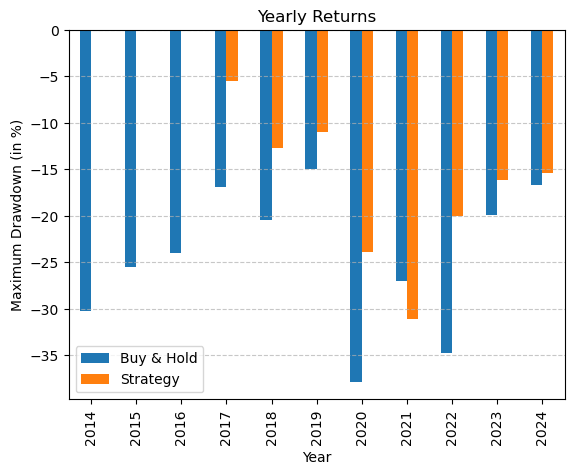

In [9]:
yearly_mdd = pd.merge(bnh_yearly_drawdowns.rename('Buy & Hold').reset_index(),
                           strategy_yearly_drawdowns.rename('Strategy').reset_index(),
                            how='inner').dropna()
# Plot Yearly Returns
plt.figure(figsize=(12, 10))

yearly_mdd.plot(x='Year', 
        kind='bar', 
        stacked=False, 
        title='Yearly Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Maximum Drawdown (in %)')
plt.show()

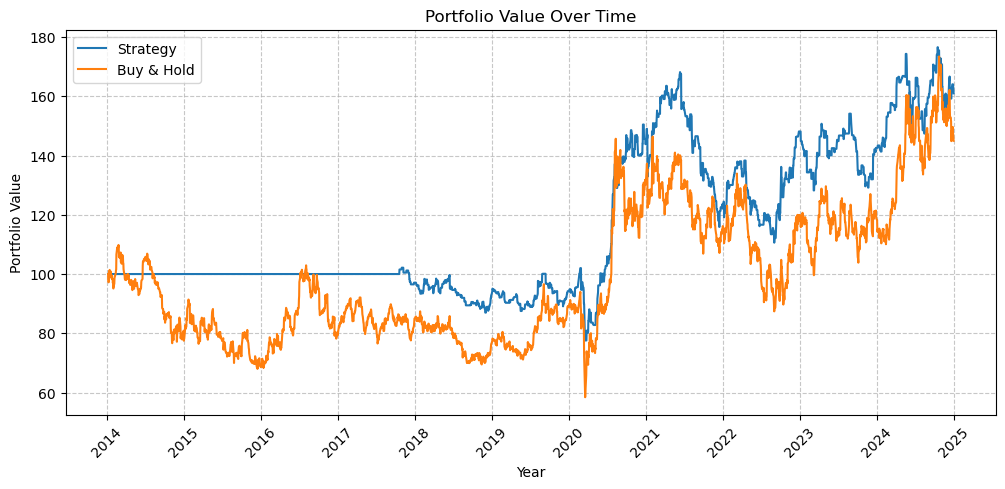

In [10]:
import matplotlib.dates as mdates

initial_value = 100
plt.figure(figsize=(12, 5))

# Compute the portfolio value over time
df = strategy_returns
df["Portfolio Value"] = initial_value * (1 + df["Returns"]).cumprod()
plt.plot(df.index,
         df["Portfolio Value"],
         label="Strategy")

df = bnh_returns
df["Portfolio Value"] = initial_value * (1 + df["Returns"]).cumprod()
plt.plot(df.index,
         df["Portfolio Value"],
         label="Buy & Hold")

# Format the x-axis to show every year
plt.xlabel("Year")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to show every year
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Set major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as year

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()